In [1]:
import pandas as pd
import numpy as np
import sys, os, re, json

import nltk
#from nltk.tokenize import word_tokenize
#from nltk import pos_tag
#from nltk.corpus import stopwords
#from nltk.stem import WordNetLemmatizer
#from nltk.corpus import wordnet as wn

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

#Models
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn import model_selection, naive_bayes, svm
from sklearn.naive_bayes import MultinomialNB #naive_bayes

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
from collections import defaultdict, Counter
from typing import List, Tuple, Dict

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
from IPython.core.pylabtools import figsize
figsize(5, 5)
sns.set()


from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#### Important Functions

In [2]:
#### Missing Values Analysis

def assess_NA(data):
    """
    Returns a pandas dataframe denoting the total number of NA values and the 
    percentage of NA values in each column.    The column names are noted on 
    the index.
    
    Parameters
    ----------
    data: dataframe
    """
    # pandas series denoting features and the sum of their null values
    null_sum = data.isnull().sum()# instantiate columns for missing data
    total = null_sum.sort_values(ascending=False)
    percent = ( ((null_sum / len(data.index))*100).round(2) ).sort_values(ascending=False)
        # concatenate along the columns to create the complete dataframe
    df_NA = pd.concat([total, percent], axis=1, keys=['Number of NA', 'Percent NA'])  
        # drop rows that don't have any missing data; omit if you want to keep all rows
    df_NA = df_NA[ (df_NA.T != 0).any() ]
    return df_NA

In [3]:
def pandas_freq(data,col):
    """
    Creates a frequency table with the percentages for a given column of a pandas dataframe. 
    """
    count = pd.crosstab(index=data[col].astype(str),columns="count").sort_values(by=[col],ascending=False).values
    
    percent = ( ((count / len(data.index))*100).round(4) )
        # concatenate along the columns to create the complete dataframe
    df_freq = pd.concat([pd.DataFrame(count, columns=["Count"]), 
                         pd.DataFrame(percent, columns= ["Percent"])], axis=1) 
    
    
    indexes = data[col].value_counts(normalize=False).index
    df_freq.set_index(indexes, inplace = True,drop = True)
    
    return df_freq

In [4]:
def evaluate_model_Xy(model, X, y, y_pred=None, label="Training", model_name="model"):
    if y_pred is None:
        y_pred = model.predict(X)

    print(label + ' Set')
    print("Accuracy:", accuracy_score(y, y_pred))
    print()

    print(classification_report(y, y_pred, digits=4))
    disp = plot_confusion_matrix(model, X, y, cmap=plt.cm.PuBuGn, normalize='true')
    #plt.savefig(model_name + "_" + label.lower() + ".eps")
    plt.show()
    print()

In [5]:
def evaluate_model(model, model_name="model", y_train_pred=None, y_dev_pred=None, y_test_pred=None):
    evaluate_model_Xy(model, X_train, y_train, label="Training", model_name=model_name)
    evaluate_model_Xy(model, X_dev, y_dev, label="Validation", model_name=model_name)
    evaluate_model_Xy(model, X_test, y_test, label="Testing", model_name=model_name)

In [6]:
%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akarunakaran1\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\akarunakaran1\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\akarunakaran1\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [7]:
missing_values = ["n/a", "na", "--", "nan"] # Making a list of missing value types
train = pd.read_csv('CrystalBall_customerReviews_preprocessed.csv', low_memory=False, delimiter =',', na_values = missing_values)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947524 entries, 0 to 947523
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ProductID              947524 non-null  object 
 1   Rating                 947524 non-null  int64  
 2   reviewText             947502 non-null  object 
 3   reviewTime             947524 non-null  object 
 4   reviewerID             947524 non-null  object 
 5   summary                947523 non-null  object 
 6   std_rating             947524 non-null  float64
 7   Review_Content_Parsed  947446 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 57.8+ MB


#### Missing Values

In [9]:
assess_NA(train)

,Number of NA,Percent NA
Review_Content_Parsed,78,0.01
reviewText,22,0.00
summary,1,0.00


#### Those missing values are just a really small fraction of the data so they'll be removed

In [10]:
missing_indexes = train[train['summary'].isnull()].index.tolist() +train[train['reviewText'].isnull()].index.tolist() + train[train['Review_Content_Parsed'].isnull()].index.tolist()
display(len(missing_indexes))

missing_indexes = list(set(missing_indexes))
display(len(missing_indexes))

train = train.drop(train.index[missing_indexes]) #removes the observation where actual y is null
train.shape

101

79

(947445, 8)

### Data Distribution

In [11]:
pandas_freq(train,"Rating")

,Count,Percent
5,560232,59.1308
4,244000,25.7535
3,91175,9.6232
2,31025,3.2746
1,21013,2.2179


In [12]:
pandas_freq(train,"std_rating")

,Count,Percent
1.00,560232,59.1308
0.75,244000,25.7535
0.50,91175,9.6232
0.25,31025,3.2746
0.00,21013,2.2179


We're dealing with imbalanced data here.

### Data Preprocessing and Split

We need to seperate training, validation, and testing sets.

* Training set: balanced dataset
* Validation/Testing set: raw (imbalanced) dataset

In [13]:
df_train_raw, df_test = train_test_split(train, test_size=20000, random_state=42, shuffle=True)

df_train_raw, df_dev = train_test_split(df_train_raw, test_size=20000, random_state=42, shuffle=True)

#here we select the test_size as a number close to the count of the lowest class

In [14]:
pandas_freq(df_train_raw,"Rating")

,Count,Percent
5,536518,59.1240
4,233727,25.7566
3,87254,9.6153
2,29782,3.2820
1,20164,2.2221


In [15]:
from sklearn.utils import resample

def undersample(df,col, group_size=20000):
    dfs = []

    for label in df[col].value_counts().keys():
        df_group = df[df[col] == label]
        df_group_undersampled = resample(df_group, 
                                       replace=False, 
                                       n_samples=group_size, 
                                       random_state=42)
        dfs.append(df_group_undersampled)

    return pd.concat(dfs).sample(frac=1, random_state=42)

In [16]:
df_train = undersample(df_train_raw,"Rating")

### Check Distribution of the Rating in each dataset

In [17]:
pandas_freq(df_train,"Rating")

,Count,Percent
5,20000,20.0
4,20000,20.0
3,20000,20.0
2,20000,20.0
1,20000,20.0


In [18]:
pandas_freq(df_dev,"Rating")

,Count,Percent
5,11941,59.705
4,5064,25.320
3,1949,9.745
2,635,3.175
1,411,2.055


In [19]:
pandas_freq(df_test,"Rating")

,Count,Percent
5,11773,58.865
4,5209,26.045
3,1972,9.860
2,608,3.040
1,438,2.190


In [20]:
df_train["num_Review_Content_Parsed"] = df_train["Review_Content_Parsed"].map(len)

<AxesSubplot:xlabel='num_Review_Content_Parsed', ylabel='Density'>

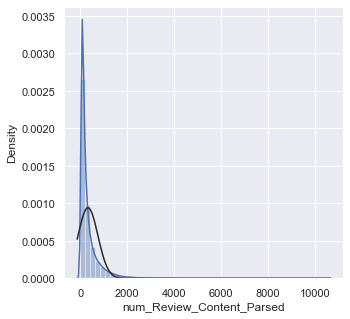

In [21]:
#Check the frequency of tokens per review and compare it with the preprocessed review
figsize(5,5)
sns.set()
from scipy.stats import norm
sns.distplot(df_train["num_Review_Content_Parsed"],fit=norm)

In [22]:
print(len(df_train[df_train["num_Review_Content_Parsed"] <= 800]) / len(df_train["num_Review_Content_Parsed"]))
print(len(df_train[df_train["num_Review_Content_Parsed"] <= 900]) / len(df_train["num_Review_Content_Parsed"]))

0.89691
0.91606


From the result, we can see most reviews are shorter than 900 meaningful tokens.

### Vectorization (Detailed)

We will try following settings for vectorization.

* With Tfidftransformer you will systematically compute word counts using CountVectorizer and then compute the Inverse Document Frequency (IDF) values and only then compute the Tf-idf scores.

* With Tfidfvectorizer on the contrary, you will do all three steps at once. Under the hood, it computes the word counts, IDF values, and Tf-idf scores all using the same dataset.

* Word representation: CountVectorizer (to count the number of words (term frequency)) vs. TfidfVectorizer (to get the tf-idf scores of a set of documents at once)

With Tfidfvectorizer you compute the word counts, idf and tf-idf values all at once. It’s really simple.

The more common the word across documents, the lower its score and the more unique a word is to our first document (e.g. ‘time read’ and ‘next book	’) the higher the score. 

# Models using unigrams only

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def extract_features(df_train, df_dev, df_test):
    vectorizer = TfidfVectorizer(analyzer='word', 
                                 #stop_words='english',
                                 ngram_range=(1, 2)
                                 #lowercase=True,
                                 #min_df=5,
                                 #max_features=300,
                                 #binary=False
                                )
    X_train = vectorizer.fit_transform(df_train["Review_Content_Parsed"])
    X_dev = vectorizer.transform(df_dev["Review_Content_Parsed"])
    X_test = vectorizer.transform(df_test["Review_Content_Parsed"])
    
    y_train = df_train["Rating"].tolist()
    y_dev = df_dev["Rating"].tolist()
    y_test = df_test["Rating"].tolist()
    
    return X_train, X_dev, X_test, y_train, y_dev, y_test

In [19]:
%time X_train, X_dev, X_test, y_train, y_dev, y_test = extract_features(df_train, df_dev, df_test)

Wall time: 20.7 s


#### Logistic Regression

In [21]:
clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=42,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [23]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.2min finished


LogisticRegression(C=5.0, class_weight='balanced', n_jobs=-1, random_state=42,
                   verbose=1)

Training Set
Accuracy: 0.94752

              precision    recall  f1-score   support

           1     0.9489    0.9570    0.9530     20000
           2     0.9502    0.9450    0.9476     20000
           3     0.9331    0.9272    0.9301     20000
           4     0.9557    0.9387    0.9471     20000
           5     0.9498    0.9696    0.9596     20000

    accuracy                         0.9475    100000
   macro avg     0.9475    0.9475    0.9475    100000
weighted avg     0.9475    0.9475    0.9475    100000



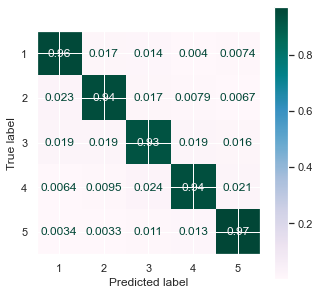


Validation Set
Accuracy: 0.58445

              precision    recall  f1-score   support

           1     0.2914    0.6204    0.3966       411
           2     0.2500    0.4583    0.3235       635
           3     0.3328    0.4572    0.3852      1949
           4     0.4031    0.4520    0.4262      5064
           5     0.8290    0.6669    0.7391     11941

    accuracy                         0.5845     20000
   macro avg     0.4213    0.5309    0.4541     20000
weighted avg     0.6434    0.5845    0.6052     20000



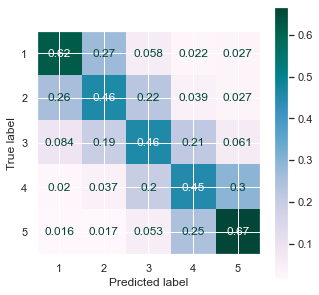


Testing Set
Accuracy: 0.5897

              precision    recall  f1-score   support

           1     0.3128    0.6598    0.4244       438
           2     0.2337    0.4309    0.3031       608
           3     0.3295    0.4452    0.3787      1972
           4     0.4226    0.4602    0.4406      5209
           5     0.8284    0.6768    0.7450     11773

    accuracy                         0.5897     20000
   macro avg     0.4254    0.5346    0.4583     20000
weighted avg     0.6442    0.5897    0.6091     20000



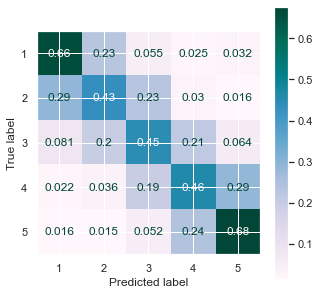

In [31]:
evaluate_model(clf_lr)

#### Linear Support Vector Machine (SVM)

In [32]:
clf_sgd = make_pipeline(StandardScaler(with_mean=False),
                        SGDClassifier(loss='hinge',
                                      penalty='l2',
                                      alpha=30,
                                      max_iter=1000, 
                                      tol=1e-3,
                                      shuffle=True,
                                      verbose=1,
                                      n_jobs=-1,
                                      random_state=0,
                                      learning_rate='optimal',
                                      early_stopping=True,
                                      class_weight='balanced'))

In [67]:
clf_sgd.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


-- Epoch 1-- Epoch 1
-- Epoch 1

-- Epoch 1-- Epoch 1

Norm: 0.17, NNZs: 1413054, Bias: -0.005400, T: 90000, Avg. loss: 0.528430Norm: 0.17, NNZs: 1424915, Bias: -0.006074, T: 90000, Avg. loss: 0.559161
Total training time: 0.39 seconds.

Total training time: 0.39 seconds.
Norm: 0.17, NNZs: 1494959, Bias: -0.006187, T: 90000, Avg. loss: 0.567437
Total training time: 0.39 seconds.
Norm: 0.16, NNZs: 1327298, Bias: -0.005657, T: 90000, Avg. loss: 0.520063Norm: 0.17, NNZs: 1563642, Bias: -0.006200, T: 90000, Avg. loss: 0.566079
Total training time: 0.39 seconds.

Total training time: 0.39 seconds.
-- Epoch 2-- Epoch 2

-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 0.14, NNZs: 1644047, Bias: -0.005479, T: 180000, Avg. loss: 0.334038
Total training time: 0.86 seconds.
Norm: 0.14, NNZs: 1656289, Bias: -0.006154, T: 180000, Avg. loss: 0.358560
Total training time: 0.87 seconds.
Norm: 0.14, NNZs: 1722192, Bias: -0.006269, T: 180000, Avg. loss: 0.355383
Total training time: 0.88 seconds.
Norm: 0.14, NNZ

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.0s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('sgdclassifier',
                 SGDClassifier(alpha=30, class_weight='balanced',
                               early_stopping=True, n_jobs=-1, random_state=0,
                               verbose=1))])

Training Set
Accuracy: 0.93932

              precision    recall  f1-score   support

           1     0.9350    0.9623    0.9484     20000
           2     0.9445    0.9222    0.9332     20000
           3     0.9515    0.9201    0.9355     20000
           4     0.9485    0.9199    0.9340     20000
           5     0.9192    0.9721    0.9449     20000

    accuracy                         0.9393    100000
   macro avg     0.9397    0.9393    0.9392    100000
weighted avg     0.9397    0.9393    0.9392    100000



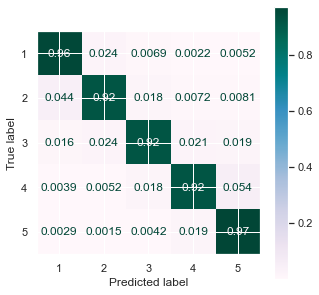


Validation Set
Accuracy: 0.5443

              precision    recall  f1-score   support

           1     0.2290    0.6423    0.3376       411
           2     0.1707    0.3685    0.2333       635
           3     0.2733    0.3166    0.2933      1949
           4     0.3720    0.4007    0.3858      5064
           5     0.7929    0.6484    0.7134     11941

    accuracy                         0.5443     20000
   macro avg     0.3676    0.4753    0.3927     20000
weighted avg     0.6044    0.5443    0.5665     20000



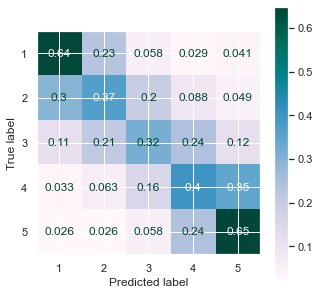


Testing Set
Accuracy: 0.53975

              precision    recall  f1-score   support

           1     0.2211    0.5982    0.3229       438
           2     0.1577    0.3569    0.2187       608
           3     0.2678    0.3230    0.2928      1972
           4     0.3784    0.3843    0.3813      5209
           5     0.7859    0.6521    0.7127     11773

    accuracy                         0.5397     20000
   macro avg     0.3622    0.4629    0.3857     20000
weighted avg     0.5972    0.5397    0.5615     20000



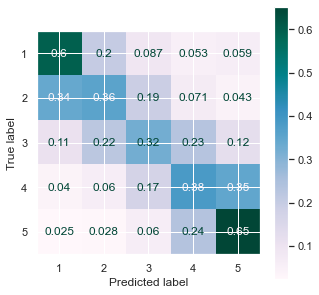

In [68]:
evaluate_model(clf_sgd, model_name="sgd")

#### Naive Bayes


In [69]:
clf_nb = MultinomialNB(alpha=0.5,
                       fit_prior=True)

In [70]:
%time clf_nb.fit(X_train, y_train)

Wall time: 451 ms


MultinomialNB(alpha=0.5)

Training Set
Accuracy: 0.95616

              precision    recall  f1-score   support

           1     0.9656    0.9483    0.9569     20000
           2     0.9570    0.9584    0.9577     20000
           3     0.9454    0.9549    0.9501     20000
           4     0.9557    0.9527    0.9542     20000
           5     0.9575    0.9665    0.9620     20000

    accuracy                         0.9562    100000
   macro avg     0.9562    0.9562    0.9562    100000
weighted avg     0.9562    0.9562    0.9562    100000



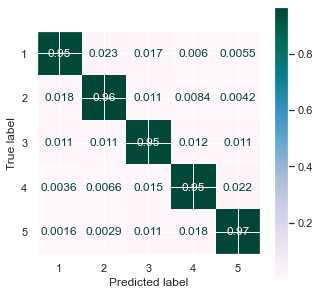


Validation Set
Accuracy: 0.54715

              precision    recall  f1-score   support

           1     0.3463    0.5401    0.4221       411
           2     0.2693    0.4882    0.3471       635
           3     0.3439    0.4520    0.3906      1949
           4     0.3651    0.5634    0.4430      5064
           5     0.8526    0.5592    0.6754     11941

    accuracy                         0.5472     20000
   macro avg     0.4354    0.5206    0.4556     20000
weighted avg     0.6507    0.5472    0.5732     20000



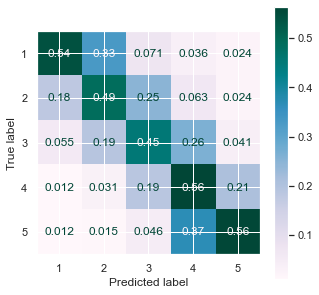


Testing Set
Accuracy: 0.55575

              precision    recall  f1-score   support

           1     0.3872    0.5525    0.4553       438
           2     0.2588    0.5066    0.3426       608
           3     0.3382    0.4366    0.3811      1972
           4     0.3838    0.5730    0.4597      5209
           5     0.8547    0.5707    0.6844     11773

    accuracy                         0.5557     20000
   macro avg     0.4445    0.5279    0.4646     20000
weighted avg     0.6528    0.5557    0.5806     20000



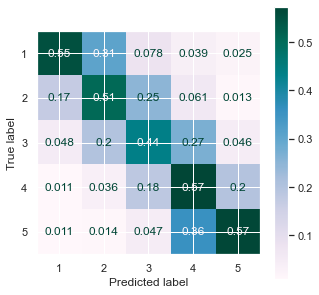

In [71]:
evaluate_model(clf_nb, model_name="nb")

#### Random Forest Classifier

In [60]:
clf_rf = RandomForestClassifier(n_estimators=500,
                                criterion="gini",
                                max_depth=None, 
                                min_samples_split=2,
                                min_samples_leaf=10, 
                                max_features="auto", 
                                n_jobs=-1,
                                verbose=1,
                                random_state=0,
                                class_weight='balanced')

In [72]:
clf_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished


RandomForestClassifier(class_weight='balanced', min_samples_leaf=10,
                       n_estimators=500, n_jobs=-1, random_state=0, verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   33.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  1.5min finished


Training Set
Accuracy: 0.55983

              precision    recall  f1-score   support

           1     0.5528    0.7684    0.6430     20000
           2     0.5542    0.4126    0.4730     20000
           3     0.5747    0.3862    0.4620     20000
           4     0.5084    0.4904    0.4993     20000
           5     0.6034    0.7415    0.6654     20000

    accuracy                         0.5598    100000
   macro avg     0.5587    0.5598    0.5485    100000
weighted avg     0.5587    0.5598    0.5485    100000



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   32.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  1.5min finished


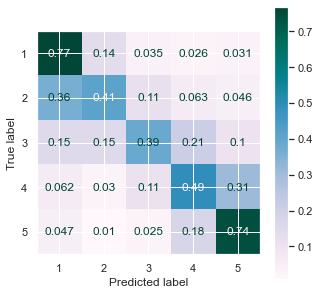

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   11.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   13.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Validation Set
Accuracy: 0.5858

              precision    recall  f1-score   support

           1     0.1692    0.7226    0.2742       411
           2     0.2160    0.3528    0.2679       635
           3     0.3526    0.3186    0.3348      1949
           4     0.4229    0.4076    0.4151      5064
           5     0.8054    0.7127    0.7562     11941

    accuracy                         0.5858     20000
   macro avg     0.3932    0.5029    0.4096     20000
weighted avg     0.6326    0.5858    0.6034     20000



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   11.5s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   13.2s finished


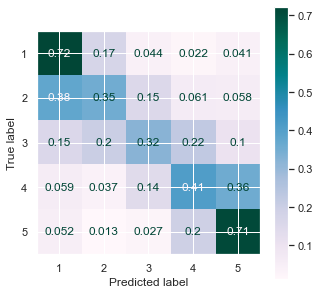

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   11.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   13.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Testing Set
Accuracy: 0.59

              precision    recall  f1-score   support

           1     0.1672    0.7352    0.2724       438
           2     0.2286    0.3651    0.2812       608
           3     0.3556    0.3185    0.3360      1972
           4     0.4529    0.4256    0.4388      5209
           5     0.8055    0.7144    0.7572     11773

    accuracy                         0.5900     20000
   macro avg     0.4020    0.5118    0.4171     20000
weighted avg     0.6378    0.5900    0.6077     20000



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   11.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   13.3s finished


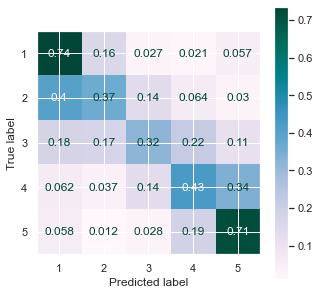

In [73]:
evaluate_model(clf_rf, model_name="rf")

# Using bi-gram

In [74]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def extract_features(df_train, df_dev, df_test):
    vectorizer = TfidfVectorizer(#analyzer='word', 
                                 #stop_words='english',
                                 ngram_range=(2, 2)
                                 #lowercase=True,
                                 #min_df=5,
                                 #max_features=300,
                                 #binary=False
                                )
    X_train = vectorizer.fit_transform(df_train["Review_Content_Parsed"])
    X_dev = vectorizer.transform(df_dev["Review_Content_Parsed"])
    X_test = vectorizer.transform(df_test["Review_Content_Parsed"])
    
    y_train = df_train["Rating"].tolist()
    y_dev = df_dev["Rating"].tolist()
    y_test = df_test["Rating"].tolist()
    
    return X_train, X_dev, X_test, y_train, y_dev, y_test

In [75]:
%time X_train, X_dev, X_test, y_train, y_dev, y_test = extract_features(df_train, df_dev, df_test)

Wall time: 15.6 s


#### Logistic Regression

In [42]:
clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=42,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [76]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.2min finished


LogisticRegression(C=5.0, class_weight='balanced', n_jobs=-1, random_state=42,
                   verbose=1)

Training Set
Accuracy: 0.9827

              precision    recall  f1-score   support

           1     0.9814    0.9862    0.9838     20000
           2     0.9903    0.9777    0.9839     20000
           3     0.9848    0.9824    0.9836     20000
           4     0.9814    0.9790    0.9802     20000
           5     0.9759    0.9882    0.9820     20000

    accuracy                         0.9827    100000
   macro avg     0.9827    0.9827    0.9827    100000
weighted avg     0.9827    0.9827    0.9827    100000



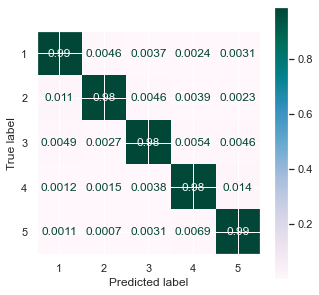


Validation Set
Accuracy: 0.5542

              precision    recall  f1-score   support

           1     0.2289    0.6010    0.3315       411
           2     0.1890    0.4205    0.2607       635
           3     0.3054    0.4007    0.3466      1949
           4     0.3942    0.4623    0.4256      5064
           5     0.8264    0.6237    0.7109     11941

    accuracy                         0.5542     20000
   macro avg     0.3888    0.5016    0.4151     20000
weighted avg     0.6337    0.5542    0.5811     20000



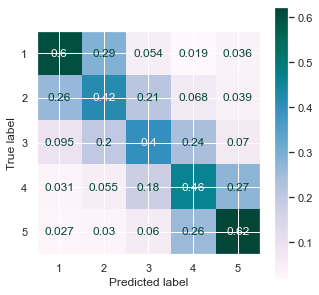


Testing Set
Accuracy: 0.55885

              precision    recall  f1-score   support

           1     0.2344    0.5936    0.3361       438
           2     0.1888    0.4145    0.2594       608
           3     0.3119    0.4042    0.3521      1972
           4     0.4103    0.4721    0.4390      5209
           5     0.8225    0.6293    0.7131     11773

    accuracy                         0.5588     20000
   macro avg     0.3936    0.5027    0.4199     20000
weighted avg     0.6327    0.5588    0.5840     20000



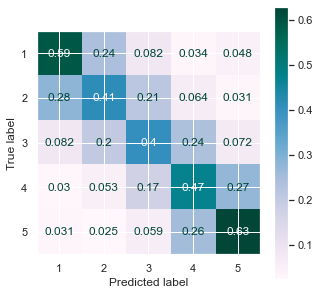

In [77]:
evaluate_model(clf_lr)

#### Linear Support Vector Machine (SVM)

In [54]:
clf_sgd = make_pipeline(StandardScaler(with_mean=False),
                        SGDClassifier(loss='hinge',
                                      penalty='l2',
                                      alpha=30,
                                      max_iter=1000, 
                                      tol=1e-3,
                                      shuffle=True,
                                      verbose=1,
                                      n_jobs=-1,
                                      random_state=0,
                                      learning_rate='optimal',
                                      early_stopping=True,
                                      class_weight='balanced'))

In [78]:
clf_sgd.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


-- Epoch 1-- Epoch 1

-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 0.18, NNZs: 1718839, Bias: -0.006434, T: 90000, Avg. loss: 0.657285
Total training time: 0.35 seconds.
Norm: 0.18, NNZs: 1851191, Bias: -0.006736, T: 90000, Avg. loss: 0.706623Norm: 0.18, NNZs: 1767414, Bias: -0.005745, T: 90000, Avg. loss: 0.666282
Total training time: 0.36 seconds.

Total training time: 0.34 seconds.
Norm: 0.18, NNZs: 1784973, Bias: -0.006510, T: 90000, Avg. loss: 0.695845
Total training time: 0.36 seconds.
Norm: 0.18, NNZs: 1833115, Bias: -0.006712, T: 90000, Avg. loss: 0.707844
Total training time: 0.37 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2-- Epoch 2

-- Epoch 2
Norm: 0.14, NNZs: 1862245, Bias: -0.006526, T: 180000, Avg. loss: 0.416766
Total training time: 0.73 seconds.
Norm: 0.14, NNZs: 1899890, Bias: -0.006606, T: 180000, Avg. loss: 0.433328Norm: 0.14, NNZs: 1887528, Bias: -0.005840, T: 180000, Avg. loss: 0.412923
Total training time: 0.74 seconds.

Norm: 0.14, NNZs: 1925119, Bias: -0.006838, T: 180

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('sgdclassifier',
                 SGDClassifier(alpha=30, class_weight='balanced',
                               early_stopping=True, n_jobs=-1, random_state=0,
                               verbose=1))])

Training Set
Accuracy: 0.93996

              precision    recall  f1-score   support

           1     0.9461    0.9543    0.9501     20000
           2     0.9397    0.9285    0.9341     20000
           3     0.9421    0.9258    0.9339     20000
           4     0.9448    0.9252    0.9349     20000
           5     0.9277    0.9660    0.9465     20000

    accuracy                         0.9400    100000
   macro avg     0.9401    0.9400    0.9399    100000
weighted avg     0.9401    0.9400    0.9399    100000



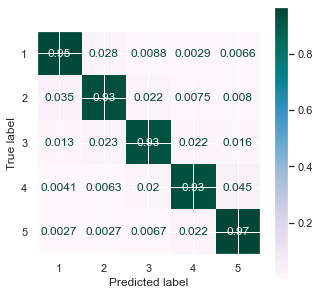


Validation Set
Accuracy: 0.4884

              precision    recall  f1-score   support

           1     0.1817    0.5353    0.2713       411
           2     0.1434    0.3843    0.2088       635
           3     0.2305    0.3253    0.2698      1949
           4     0.3383    0.3894    0.3621      5064
           5     0.7873    0.5609    0.6551     11941

    accuracy                         0.4884     20000
   macro avg     0.3362    0.4390    0.3534     20000
weighted avg     0.5864    0.4884    0.5213     20000



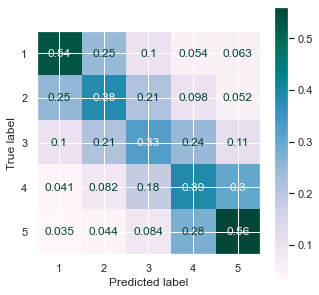


Testing Set
Accuracy: 0.48865

              precision    recall  f1-score   support

           1     0.1827    0.5068    0.2686       438
           2     0.1308    0.3635    0.1923       608
           3     0.2204    0.3240    0.2624      1972
           4     0.3516    0.3816    0.3660      5209
           5     0.7847    0.5694    0.6599     11773

    accuracy                         0.4887     20000
   macro avg     0.3340    0.4291    0.3498     20000
weighted avg     0.5832    0.4886    0.5214     20000



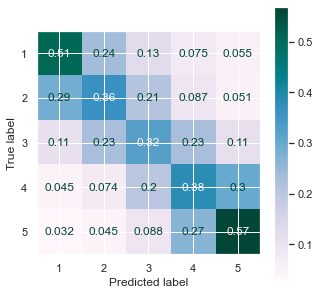

In [79]:
evaluate_model(clf_sgd, model_name="sgd")

#### Naive Bayes


In [69]:
clf_nb = MultinomialNB(alpha=0.5,
                       fit_prior=True)

In [80]:
%time clf_nb.fit(X_train, y_train)

Wall time: 379 ms


MultinomialNB(alpha=0.5)

Training Set
Accuracy: 0.97974

              precision    recall  f1-score   support

           1     0.9802    0.9814    0.9808     20000
           2     0.9834    0.9765    0.9799     20000
           3     0.9754    0.9772    0.9763     20000
           4     0.9846    0.9756    0.9801     20000
           5     0.9752    0.9880    0.9816     20000

    accuracy                         0.9797    100000
   macro avg     0.9798    0.9797    0.9797    100000
weighted avg     0.9798    0.9797    0.9797    100000



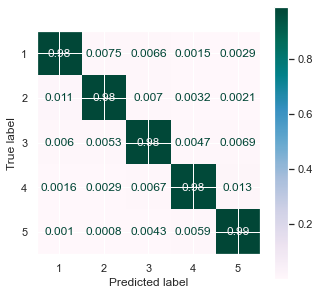


Validation Set
Accuracy: 0.56315

              precision    recall  f1-score   support

           1     0.2923    0.5839    0.3896       411
           2     0.2332    0.4803    0.3139       635
           3     0.3160    0.4572    0.3737      1949
           4     0.3868    0.4662    0.4228      5064
           5     0.8345    0.6252    0.7149     11941

    accuracy                         0.5632     20000
   macro avg     0.4125    0.5226    0.4430     20000
weighted avg     0.6404    0.5632    0.5883     20000



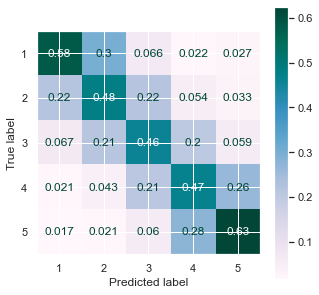


Testing Set
Accuracy: 0.5635

              precision    recall  f1-score   support

           1     0.3042    0.5890    0.4012       438
           2     0.2207    0.4638    0.2990       608
           3     0.3054    0.4326    0.3580      1972
           4     0.3998    0.4736    0.4336      5209
           5     0.8316    0.6294    0.7165     11773

    accuracy                         0.5635     20000
   macro avg     0.4123    0.5177    0.4417     20000
weighted avg     0.6371    0.5635    0.5879     20000



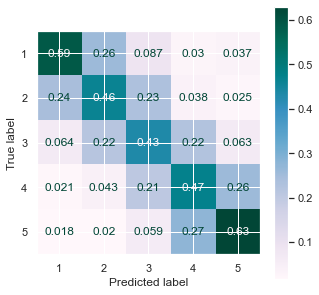

In [81]:
evaluate_model(clf_nb, model_name="nb")

#### Random Forest Classifier

In [60]:
clf_rf = RandomForestClassifier(n_estimators=500,
                                criterion="gini",
                                max_depth=None, 
                                min_samples_split=2,
                                min_samples_leaf=10, 
                                max_features="auto", 
                                n_jobs=-1,
                                verbose=1,
                                random_state=0,
                                class_weight='balanced')

In [82]:
clf_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.2min finished


RandomForestClassifier(class_weight='balanced', min_samples_leaf=10,
                       n_estimators=500, n_jobs=-1, random_state=0, verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   23.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   53.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  1.0min finished


Training Set
Accuracy: 0.55541

              precision    recall  f1-score   support

           1     0.5415    0.7125    0.6154     20000
           2     0.5263    0.4726    0.4980     20000
           3     0.5652    0.4261    0.4859     20000
           4     0.5314    0.4799    0.5043     20000
           5     0.6073    0.6860    0.6443     20000

    accuracy                         0.5554    100000
   macro avg     0.5544    0.5554    0.5496    100000
weighted avg     0.5544    0.5554    0.5496    100000



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   23.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   54.5s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  1.0min finished


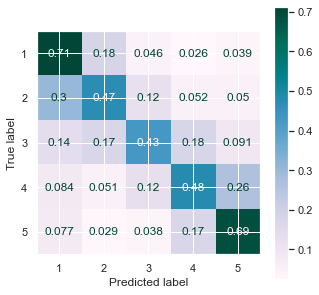

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    7.9s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    9.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Validation Set
Accuracy: 0.53945

              precision    recall  f1-score   support

           1     0.1165    0.6423    0.1972       411
           2     0.1751    0.3890    0.2414       635
           3     0.3155    0.3320    0.3235      1949
           4     0.4141    0.3833    0.3981      5064
           5     0.8024    0.6440    0.7145     11941

    accuracy                         0.5394     20000
   macro avg     0.3647    0.4781    0.3749     20000
weighted avg     0.6226    0.5394    0.5706     20000



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    8.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    9.3s finished


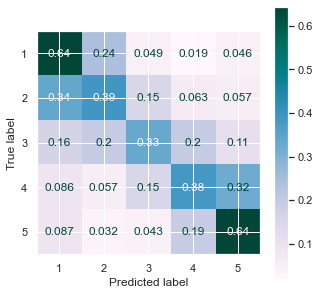

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    7.7s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    9.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Testing Set
Accuracy: 0.5469

              precision    recall  f1-score   support

           1     0.1273    0.6598    0.2134       438
           2     0.1662    0.3750    0.2303       608
           3     0.3171    0.3367    0.3266      1972
           4     0.4380    0.3912    0.4133      5209
           5     0.8032    0.6557    0.7220     11773

    accuracy                         0.5469     20000
   macro avg     0.3704    0.4837    0.3811     20000
weighted avg     0.6260    0.5469    0.5765     20000



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    7.9s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    9.1s finished


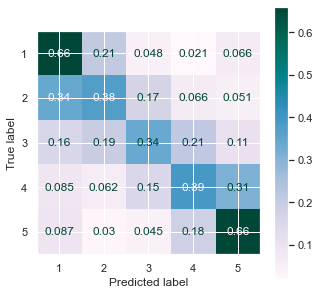

In [83]:
evaluate_model(clf_rf, model_name="rf")

# BERT

BERT (Bidirectional Encoder Representations)

In [23]:
#%pip install simpletransformers

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

datasets 1.6.1 requires tqdm<4.50.0,>=4.27, but you'll have tqdm 4.50.2 which is incompatible.



  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16175 sha256=f0169efb6265cacc15ea490121b8f9fc90a7e22e38e262bc20c468898f889831
  Stored in directory: c:\users\akarunakaran1\appdata\local\pip\cache\wheels\ad\5c\ba\05fa33fa5855777b7d686e843ec07452f22a66a138e290e732
  Created wheel for blinker: filename=blinker-1.4-py3-none-any.whl size=13454 sha256=197630b094bea055595f30a183c63e4090e05f03f68021dded04855fdccda047
  Stored in directory: c:\users\akarunakaran1\appdata\local\pip\cache\wheels\b7\a5\68\fe632054a5eadd531c7a49d740c50eb6adfbeca822b4eab8d4
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6493 sha256=6f019e0b407a89cb0406539d71f62b8cb9f3153ebd46b910ec93cbc917acde6b
  Stored in directory: c:\users\akarunakaran1\appdata\local\pip\cache\wheels\9f\69\d1\50b39b308a87998eaf5c1d9095e5a5bd2ad98501e2b7936d36
Successfully built seqeval blinker subprocess32


In [23]:
#%pip install simpletransformers
from simpletransformers.classification import ClassificationModel

In [15]:
#pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [17]:
#Tests for Maximum Sequence Level

Deep Learning (DL) models are typically run on CUDA-enabled GPUs as the performance is far, far superior compared to running on a CPU. This is especially true for Transformer models considering that they are quite large even in relation to other DL models. CUDA is enabled by default on all Simple Transformers models.

https://simpletransformers.ai/docs/usage/

df_train is a huge dataset so for performance reasons, we'll use only 4,000 sentences from this dataset

In [24]:
sample_df = df_train.groupby('Rating').apply(lambda x: x.sample(frac=0.04))
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4000 entries, (1, 49534) to (5, 20283)
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ProductID                  4000 non-null   object 
 1   Rating                     4000 non-null   int64  
 2   reviewText                 4000 non-null   object 
 3   reviewTime                 4000 non-null   object 
 4   reviewerID                 4000 non-null   object 
 5   summary                    4000 non-null   object 
 6   std_rating                 4000 non-null   float64
 7   Review_Content_Parsed      4000 non-null   object 
 8   num_Review_Content_Parsed  4000 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 484.3+ KB


In [25]:
sample_df = sample_df.reset_index(drop=True)

sample_df["Rating_adj"] = sample_df["Rating"]-1

sample_df2 = sample_df[["reviewText","Rating_adj"]]

sample_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  4000 non-null   object
 1   Rating_adj  4000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.6+ KB


In [26]:
import torch

#cuda_available = torch.cuda.is_available()

In [33]:
model_bert_base_cased_64 = \
ClassificationModel('bert', #Loading a pre-trained model
                    'bert-base-cased', #Loading a pre-trained model
                    use_cuda=False,
                    num_labels=5,
                    args={"output_dir": "outputs_bert_base_cased_64/",
                          "best_model_dir": "outputs_bert_base_cased_64/best_model/",
                          #"max_seq_length": 64,
                          "train_batch_size": 1,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 4000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          #"save_steps": 4000,
                          "save_model_every_epoch": False,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [34]:
model_bert_base_cased_64.train_model(sample_df2)

(4000, 1.5824645283576102)

In [35]:
df_dev["Rating_adj"] = df_dev["Rating"]-1
df_dev2 = df_dev[["reviewText","Rating_adj"]]
display(pandas_freq(df_dev2,"Rating_adj"))

df_test["Rating_adj"] = df_test["Rating"]-1
df_test2 = df_test[["reviewText","Rating_adj"]]
display(pandas_freq(df_test2,"Rating_adj"))

,Count,Percent
4,11941,59.705
3,5064,25.320
2,1949,9.745
1,635,3.175
0,411,2.055


,Count,Percent
4,11773,58.865
3,5209,26.045
2,1972,9.860
1,608,3.040
0,438,2.190


In [37]:
def evaluate_bert_model_one(model, df, label="Training", model_name="model"):
    y = df['Rating_adj'].tolist()
    y_pred, raw_outputs = model.predict(df['reviewText'].tolist())

    print(label + ' Set')
    print("Accuracy:", accuracy_score(y, y_pred))
    print()

    print(classification_report(y, y_pred, digits=4))
    df_cm = pd.DataFrame(confusion_matrix(y, y_pred, normalize='true'), 
                         range(1,6), range(1,6))
    plt.figure(figsize=(6,4))
    ax = sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, square=True)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    #plt.savefig(model_name + "_" + label.lower() + ".eps")
    plt.show()
    print()

def evaluate_bert_model(model, model_name="model"):
    evaluate_bert_model_one(model, df_dev2, label="Validation", model_name=model_name)
    evaluate_bert_model_one(model, df_test2, label="Testing", model_name=model_name)
    # evaluate_bert_model_one(model, df_train, label="Training", model_name=model_name)


Validation Set
Accuracy: 0.54265

              precision    recall  f1-score   support

           0     0.1783    0.7713    0.2896       411
           1     0.0894    0.0850    0.0872       635
           2     0.1881    0.2381    0.2101      1949
           3     0.3694    0.0849    0.1381      5064
           4     0.6855    0.8029    0.7396     11941

    accuracy                         0.5426     20000
   macro avg     0.3021    0.3965    0.2929     20000
weighted avg     0.5276    0.5426    0.5057     20000



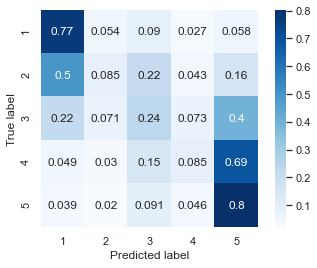


Testing Set
Accuracy: 0.5365

              precision    recall  f1-score   support

           0     0.1859    0.7420    0.2973       438
           1     0.0879    0.0872    0.0875       608
           2     0.1874    0.2287    0.2060      1972
           3     0.3650    0.0820    0.1339      5209
           4     0.6732    0.8047    0.7331     11773

    accuracy                         0.5365     20000
   macro avg     0.2999    0.3889    0.2916     20000
weighted avg     0.5166    0.5365    0.4959     20000



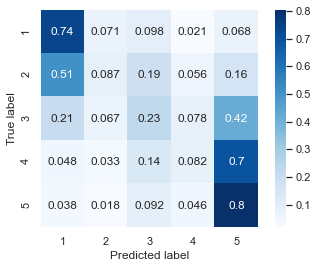

In [38]:
evaluate_bert_model(model_bert_base_cased_64, model_name="bert_base_cased_64")